# Data extraction and aggregation

In [49]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

path = r'./../data/UNSW-NB15/'

features = pd.read_csv(path + "NUSW-NB15_features.csv", encoding='cp1252')

data = pd.concat([
    pd.read_csv(path + "UNSW-NB15_1.csv", low_memory=False, names=features.Name),
    pd.read_csv(path + "UNSW-NB15_2.csv", low_memory=False, names=features.Name),
    pd.read_csv(path + "UNSW-NB15_3.csv", low_memory=False, names=features.Name),
    pd.read_csv(path + "UNSW-NB15_4.csv", low_memory=False, names=features.Name)
])

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2540047 entries, 0 to 440043
Data columns (total 49 columns):
 #   Column            Dtype  
---  ------            -----  
 0   srcip             object 
 1   sport             object 
 2   dstip             object 
 3   dsport            object 
 4   proto             object 
 5   state             object 
 6   dur               float64
 7   sbytes            int64  
 8   dbytes            int64  
 9   sttl              int64  
 10  dttl              int64  
 11  sloss             int64  
 12  dloss             int64  
 13  service           object 
 14  Sload             float64
 15  Dload             float64
 16  Spkts             int64  
 17  Dpkts             int64  
 18  swin              int64  
 19  dwin              int64  
 20  stcpb             int64  
 21  dtcpb             int64  
 22  smeansz           int64  
 23  dmeansz           int64  
 24  trans_depth       int64  
 25  res_bdy_len       int64  
 26  Sjit           

# Features Conversion

## Features which are unusable in the real world are dropped

the features are : `srcip`, `sport`, `dstip`

`srcip` and `srcport` can vary based on the client and they can be faked using vpns. `dstip` can vary depending on the hosting server. 

So there features have no meaning in a broader scenario.

In [50]:
data.drop(columns=["srcip", "sport", "dstip"], inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2540047 entries, 0 to 440043
Data columns (total 46 columns):
 #   Column            Dtype  
---  ------            -----  
 0   dsport            object 
 1   proto             object 
 2   state             object 
 3   dur               float64
 4   sbytes            int64  
 5   dbytes            int64  
 6   sttl              int64  
 7   dttl              int64  
 8   sloss             int64  
 9   dloss             int64  
 10  service           object 
 11  Sload             float64
 12  Dload             float64
 13  Spkts             int64  
 14  Dpkts             int64  
 15  swin              int64  
 16  dwin              int64  
 17  stcpb             int64  
 18  dtcpb             int64  
 19  smeansz           int64  
 20  dmeansz           int64  
 21  trans_depth       int64  
 22  res_bdy_len       int64  
 23  Sjit              float64
 24  Djit              float64
 25  Stime             int64  
 26  Ltime          

## Parsing non trivial features



In [51]:
# convert a blank space to `-1`
data["ct_ftp_cmd"] = data["ct_ftp_cmd"].apply(lambda x: int(x) if x != " " else -1)
# convert hex to int
data["dsport"] = data["dsport"].apply(lambda x: int(x, 16) if x != "-" else -1)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2540047 entries, 0 to 440043
Data columns (total 46 columns):
 #   Column            Dtype  
---  ------            -----  
 0   dsport            int64  
 1   proto             object 
 2   state             object 
 3   dur               float64
 4   sbytes            int64  
 5   dbytes            int64  
 6   sttl              int64  
 7   dttl              int64  
 8   sloss             int64  
 9   dloss             int64  
 10  service           object 
 11  Sload             float64
 12  Dload             float64
 13  Spkts             int64  
 14  Dpkts             int64  
 15  swin              int64  
 16  dwin              int64  
 17  stcpb             int64  
 18  dtcpb             int64  
 19  smeansz           int64  
 20  dmeansz           int64  
 21  trans_depth       int64  
 22  res_bdy_len       int64  
 23  Sjit              float64
 24  Djit              float64
 25  Stime             int64  
 26  Ltime          

## Setting `Nan` to `-1`

In [52]:
data["ct_flw_http_mthd"].fillna(-1,  inplace=True)
data["is_ftp_login"].fillna(-1,  inplace=True)

## Converting the nominal features

In these case the `pd.factorize` is utilized and the relation between the `new_values` and the old ones is displayed using dictionaries 

In [75]:
nominal_features = ["proto", "state", "service"]

for nominal_feature in nominal_features:
	new_values, index = pd.factorize(data[nominal_feature])

	# add the mapping function to a dictonary so it's reusable in the real scenario
	dict = {}

	column = data[nominal_feature].iloc
	for i in range(0,len(data)):
		dict[column[i]] = new_values[i]
	
	print(dict)

	# editing the data
	data[nominal_feature] = new_values

0        0
1        1
2        2
3        3
4        4
      ... 
130    130
131    131
132    132
133    133
134    134
Length: 135, dtype: int64
0      0
1      1
2      2
3      3
4      4
5      5
6      6
7      7
8      8
9      9
10    10
11    11
12    12
13    13
14    14
15    15
dtype: int64
0      0
1      1
2      2
3      3
4      4
5      5
6      6
7      7
8      8
9      9
10    10
11    11
12    12
dtype: int64


## Data cleaning

Clean `attack_cat` columns

In [54]:
# delete spaces if the attackcat is not None
data.attack_cat = data.attack_cat.apply(lambda x: str(x).strip() if str(x) != "nan" else x)

# Merge `Backdoor` and `Backdoors` as they are the same thing
data.attack_cat = data.attack_cat.apply(lambda x: "Backdoor" if x == "Backdoors" else x)

### Remove duplicates

In [55]:
data.drop_duplicates(inplace=True)

# Data reduction

## Binary classication distribution

In [56]:
attacks_summary = pd.DataFrame(data.Label.value_counts())
attacks_summary.columns.values[0] = "Occurrencies"

attacks_summary["Percentage"] = data.Label.value_counts() / len(data) * 100

attacks_summary

,Occurrencies,Percentage
0,1958546,95.170219
1,99394,4.829781


We have a very unbalanced dataset. Now let's look at the attack classes

## Multiclass classificatin distribution

In [57]:
classes_summary = pd.DataFrame(data.attack_cat.value_counts())
classes_summary.columns.values[0] = "Occurrencies"

attack_len = sum(data.Label)
classes_summary["Percentage"] = data.attack_cat.value_counts() / attack_len * 100

classes_summary

,Occurrencies,Percentage
Exploits,27599,27.767270
Generic,25285,25.439161
Fuzzers,21642,21.773950
Reconnaissance,13354,13.435419
DoS,5665,5.699539
Analysis,2184,2.197316
Backdoor,1983,1.995090
Shellcode,1511,1.520212
Worms,171,0.172043


the classes of attack are very unbalanced too

## Reduce the number of classes of attack

We would like to find similarity between classes of attacks, and then merge the most similar classes.

To reach this goal we will:
- search in the dataset to find out if two or more classes of attacks share somethin 
- study the type of attacks to see which classes are more similar in a real world scenario

Let's first see the clusterability of the data set

In [58]:
import pyclustertend as pyct

# Calculating the clusterability of the data frame in multiple samples

# get only the attack classes
attacks_data = data[data["Label"] != 0]

for sampling_size in range(10,51,10):
    sample_list = []
    
    for i in range(1,10,1):
        data_blob = attacks_data.drop(columns=["Label", "attack_cat"]).sample(20_000)
        sample_list.append(pyct.hopkins(data_blob,sampling_size))
    
    print(f'Sampled {sampling_size}: {sum(sample_list) / len(sample_list)}')

Sampled 10: 0.004894102743274242
Sampled 20: 0.005726442080539652
Sampled 30: 0.005339797985671331
Sampled 40: 0.0056505060016484015
Sampled 50: 0.0058935793327111515


The value is close to 0, so the dataset is very clusterable

## Data is clustered using k-means

In [41]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# get only the attack classes
attacks_data = data[data["Label"] != 0].drop(columns=["Label", "attack_cat"])

silhouette_list = []
inertia_list=[]

for n_clusters in range(2,25):
    kmeans = KMeans(n_clusters=n_clusters)
    y_pred = kmeans.fit_predict(attacks_data)

    # evaluate silhouette score
    silhouetteavg = silhouette_score(attacks_data,y_pred)
    silhouette_list.append(silhouetteavg)

    # evaluate inertia
    inertia_list.append(kmeans.inertia_)


plt.tight_layout()

# plot silhouette and inertia trends w.r.t the number of clusters
fig, ax1 = plt.subplots()
ax1.set_xlabel('k')
ax1.set_ylabel('avg-silhouette', color='black')
ax1.plot(range(2,25),silhouette_list,'--ok')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(axis='y')

ax2 = ax1.twinx()
ax2.set_ylabel('loss', color='red')
ax2.plot(range(2,25), inertia_list,'--or',alpha = 0.2)
ax2.tick_params(axis='y', labelcolor='red')

plt.tight_layout()  # otherwise the right y-label is slightly clipped

c:\Users\aless\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KeyboardInterrupt: 

Using the silhouette method we can see that the optimal number of clusters is 4. So we will utilize that number to cluster the data without sampling.

In [59]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

attacks_data = data[data["Label"] != 0].drop(columns="Label").dropna()

n_clusters = 4
    
# Clustering
cluster = KMeans(n_clusters = n_clusters)
attacks_data["cluster"] = cluster.fit_predict(attacks_data.drop(columns="attack_cat"))

# count the elements in every cluster
counts = attacks_data.groupby('cluster')['attack_cat'].value_counts()

table = pd.DataFrame()

for i in range(0, n_clusters):
    table["C" + str(i)] = pd.DataFrame(counts[i])

table.div(table.sum(axis=0), axis=1).round(4) * 100

c:\Users\aless\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,C0,C1,C2,C3
attack_cat,,,,
Exploits,45.97,10.76,46.51,45.43
Fuzzers,26.70,17.36,26.03,26.65
Reconnaissance,12.92,14.08,12.86,12.46
DoS,5.99,5.35,5.99,6.23
Generic,5.47,43.95,5.60,5.90
Shellcode,1.34,1.66,1.35,1.43
Analysis,0.84,3.45,0.81,0.91
Backdoor,0.57,3.31,0.59,0.62
Worms,0.20,0.07,0.24,0.39


## Find out which classes of attack are more similar

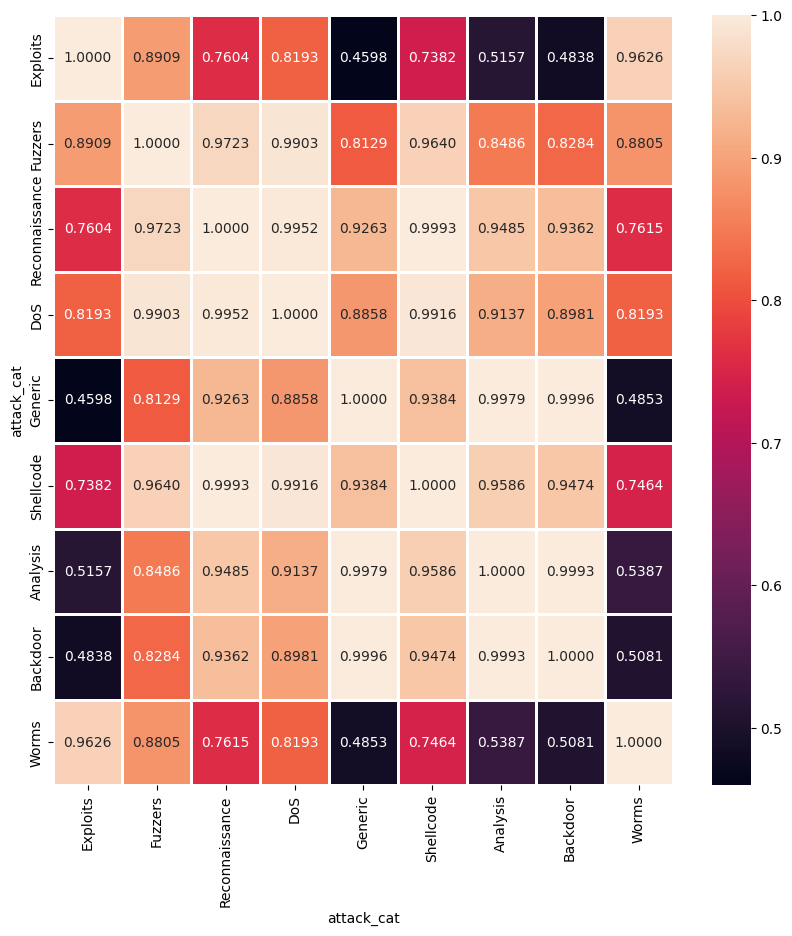

In [60]:
from sklearn.metrics.pairwise import cosine_similarity

f,ax = plt.subplots(figsize=(10,10))

similarities = cosine_similarity(table)

sns.heatmap(
	pd.DataFrame(similarities, columns = table.index, index = table.index), 
	annot=True, linewidths=1, fmt= '0.4f',ax=ax
)

plt.show()

We can clearly see that:

- `Fuzzers` and `DoS`
- `Shellcode` and `Reconnaissance`
- `Analysis` and `Backdoor`

act similarly.

Based on that we would like to merge these classes but `Analysis` and `Backdoor` attacks have nothing in common in the real word, the `Analysis` category in fact has more in common with `Shellcode` and `Reconnaissance` so we will merge it with them.

Another category of attack to consider is `Worms` which is, based on our knowledge, similar to `Exploits`.

### Class merge conclusions

the classes that will be created are:
- `Worms/Exploits`
- `Fuzzers/DoS`
- `Shellcode/Analysis/Recon`

`BackDoor` will be discarded because despite having a behavior similar to other features, if merged with them will bring no more information on the attack. 

In [61]:
data_merged = data.dropna()

data_merged = data_merged[data_merged['attack_cat'] != 'Backdoor']

data_merged.attack_cat = data_merged.attack_cat.apply(lambda x: "Worms/Exploits" if x == "Worms" or x == "Exploits" else x)
data_merged.attack_cat = data_merged.attack_cat.apply(lambda x: "Fuzzers/DoS" if x == "Fuzzers" or x == "DoS" else x)
data_merged.attack_cat = data_merged.attack_cat.apply(lambda x: "Shellcode/Analysis/Recon" if x == "Analysis" or x == "Reconnaissance" or x == "Shellcode" else x)

classes_summary = pd.DataFrame(data_merged.attack_cat.value_counts())
classes_summary.columns.values[0] = "Occurrencies"

# attack_len = sum(data.Label)
classes_summary["Percentage"] = data_merged.attack_cat.value_counts() / len(data_merged)

classes_summary

,Occurrencies,Percentage
Worms/Exploits,27770,0.285081
Fuzzers/DoS,27307,0.280328
Generic,25285,0.259570
Shellcode/Analysis/Recon,17049,0.175021


## Re-adding non attack rows

In [70]:
data_reduced = pd.concat([data_merged,data[data.Label == 0].sample(100_000)])
data_reduced['Label'].value_counts()

0    100000
1     97411
Name: Label, dtype: int64

## Plot the features correlation

C:\Users\aless\AppData\Local\Temp\ipykernel_6700\667809642.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data_without_label.corr()


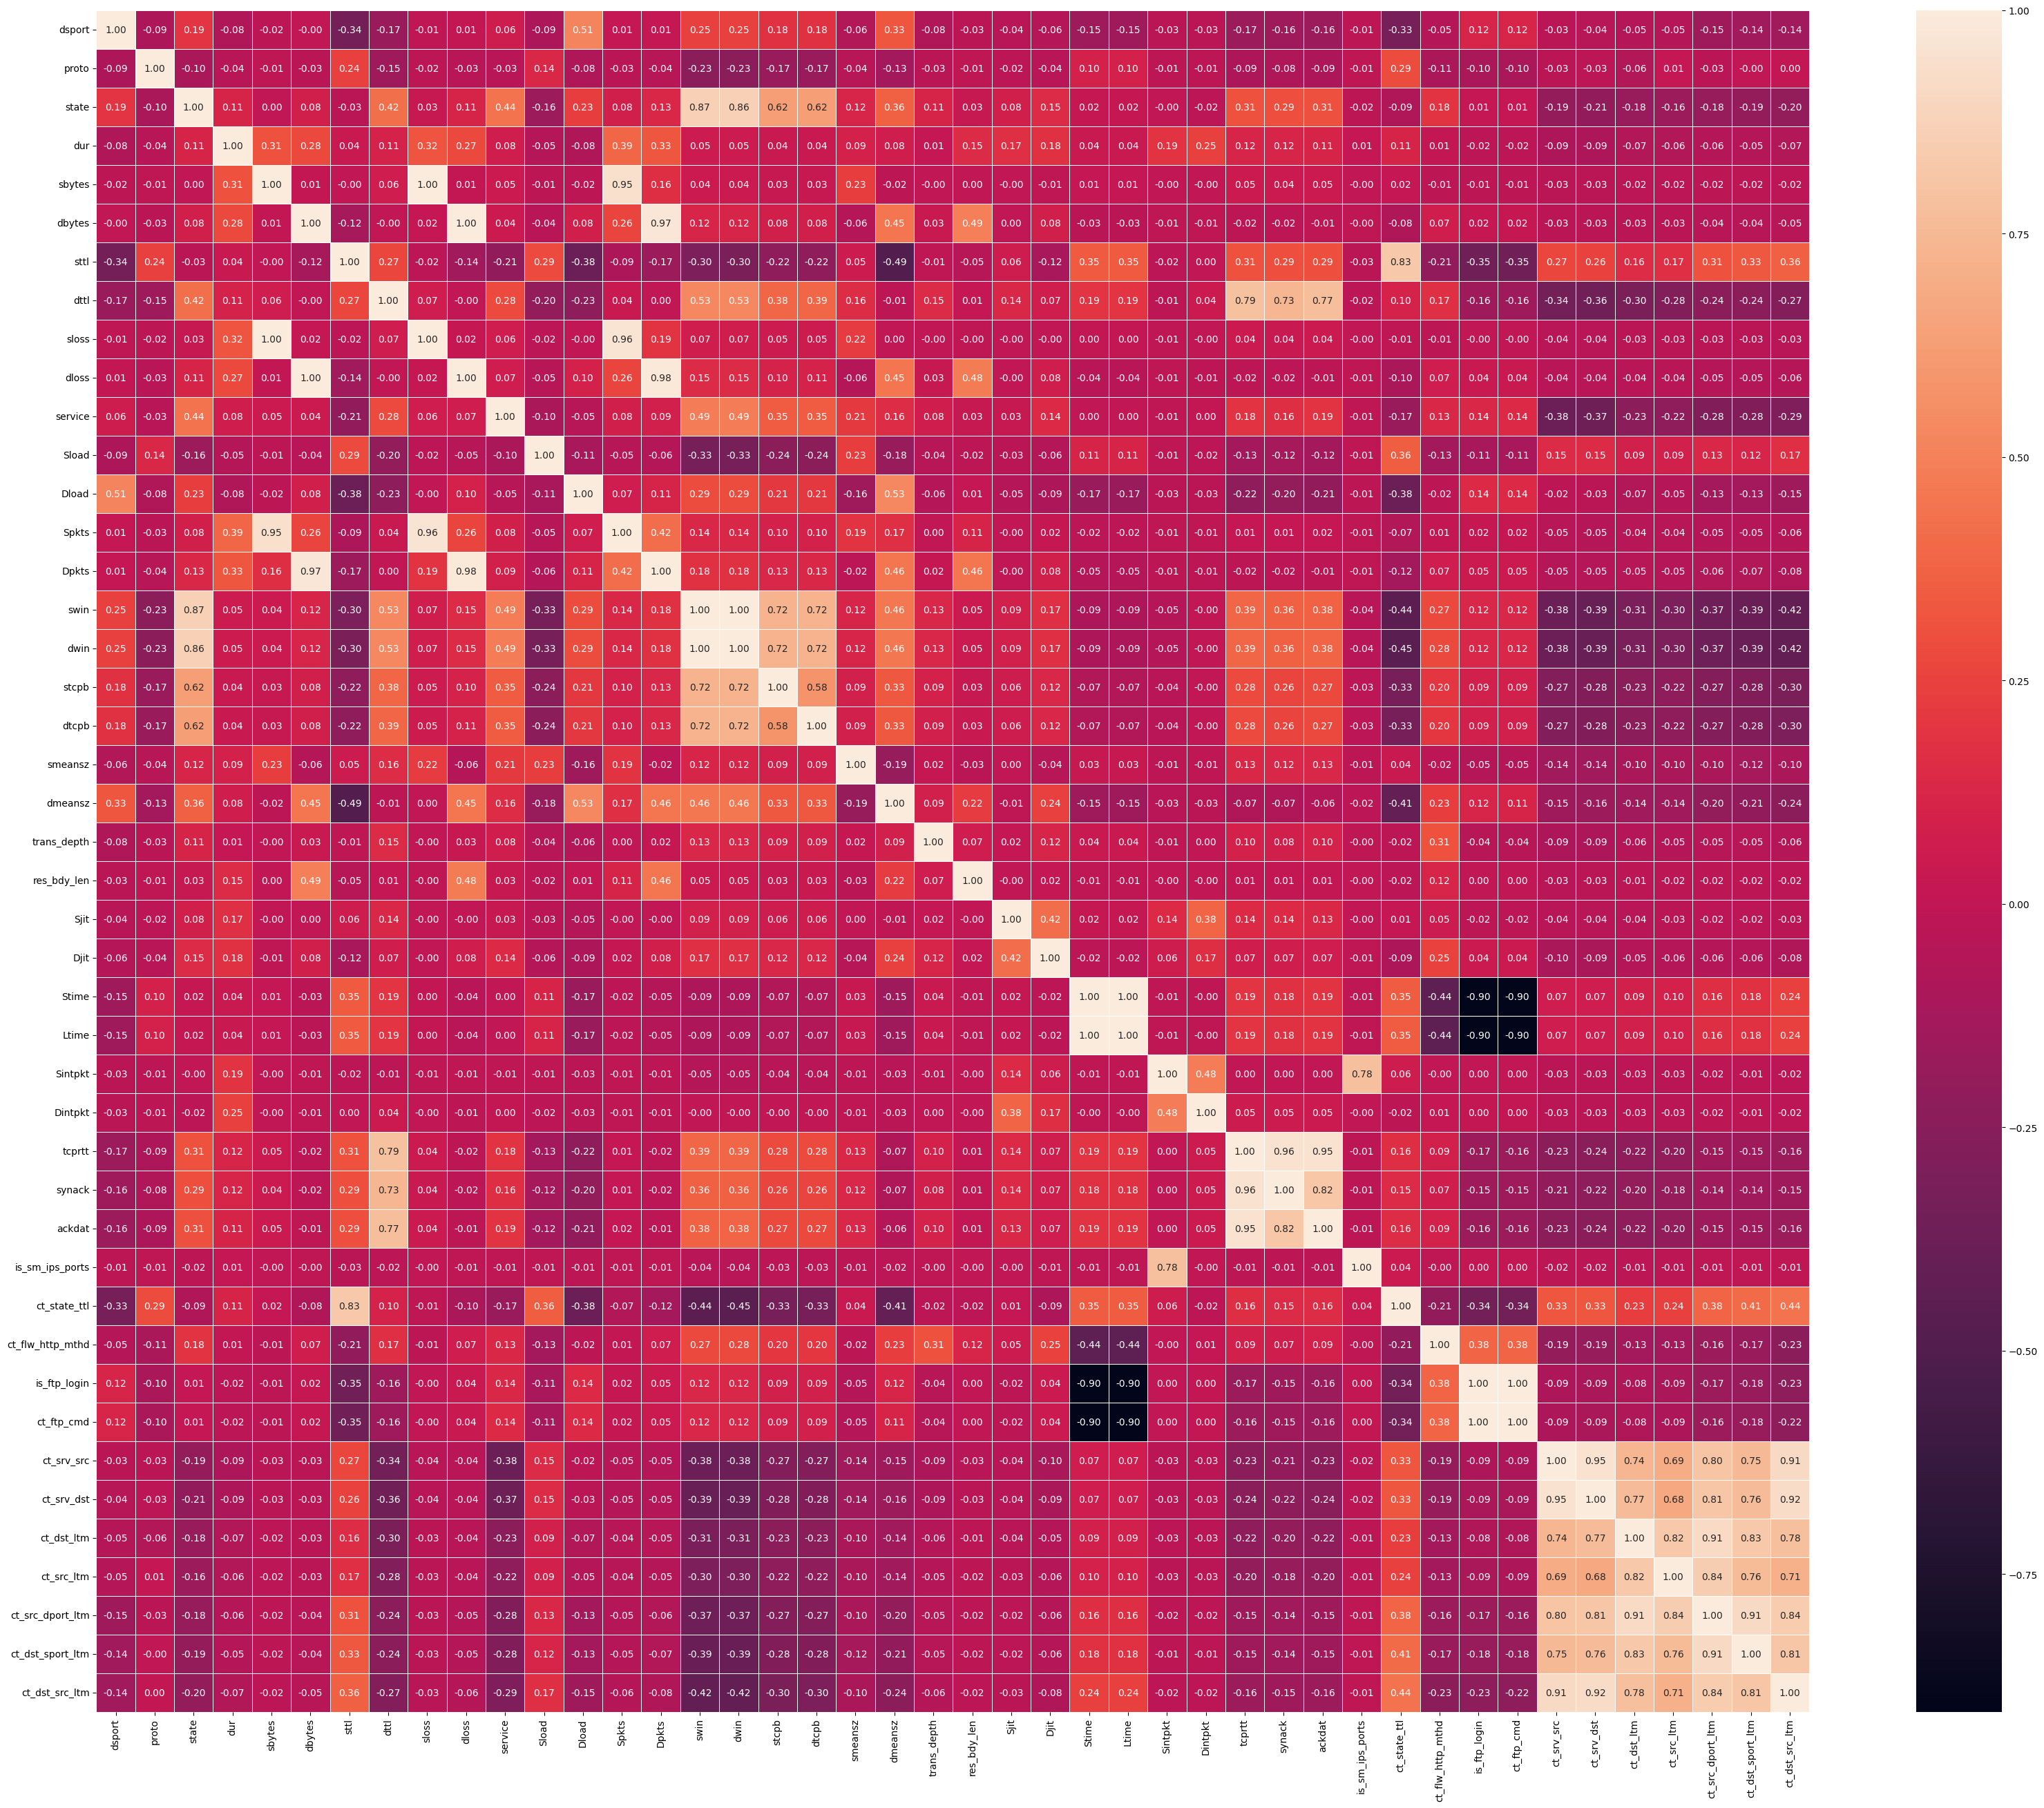

In [71]:
f,ax = plt.subplots(figsize=(40,32))

data_without_label = data_reduced.drop(columns=['Label'])

correlation_matrix = data_without_label.corr()

sns.heatmap(correlation_matrix, annot=True, linewidths=0.5, fmt= '.2f',ax=ax)
plt.show()

Drop the over-correlated features

<class 'pandas.core.frame.DataFrame'>
Int64Index: 197411 entries, 20 to 138488
Data columns (total 32 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   dsport            197411 non-null  int64  
 1   proto             197411 non-null  int64  
 2   state             197411 non-null  int64  
 3   dur               197411 non-null  float64
 4   sbytes            197411 non-null  int64  
 5   dbytes            197411 non-null  int64  
 6   sttl              197411 non-null  int64  
 7   dttl              197411 non-null  int64  
 8   service           197411 non-null  int64  
 9   Sload             197411 non-null  float64
 10  Dload             197411 non-null  float64
 11  swin              197411 non-null  int64  
 12  stcpb             197411 non-null  int64  
 13  dtcpb             197411 non-null  int64  
 14  smeansz           197411 non-null  int64  
 15  dmeansz           197411 non-null  int64  
 16  trans_depth       1

C:\Users\aless\AppData\Local\Temp\ipykernel_6700\50174470.py:20: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data_without_label.corr()


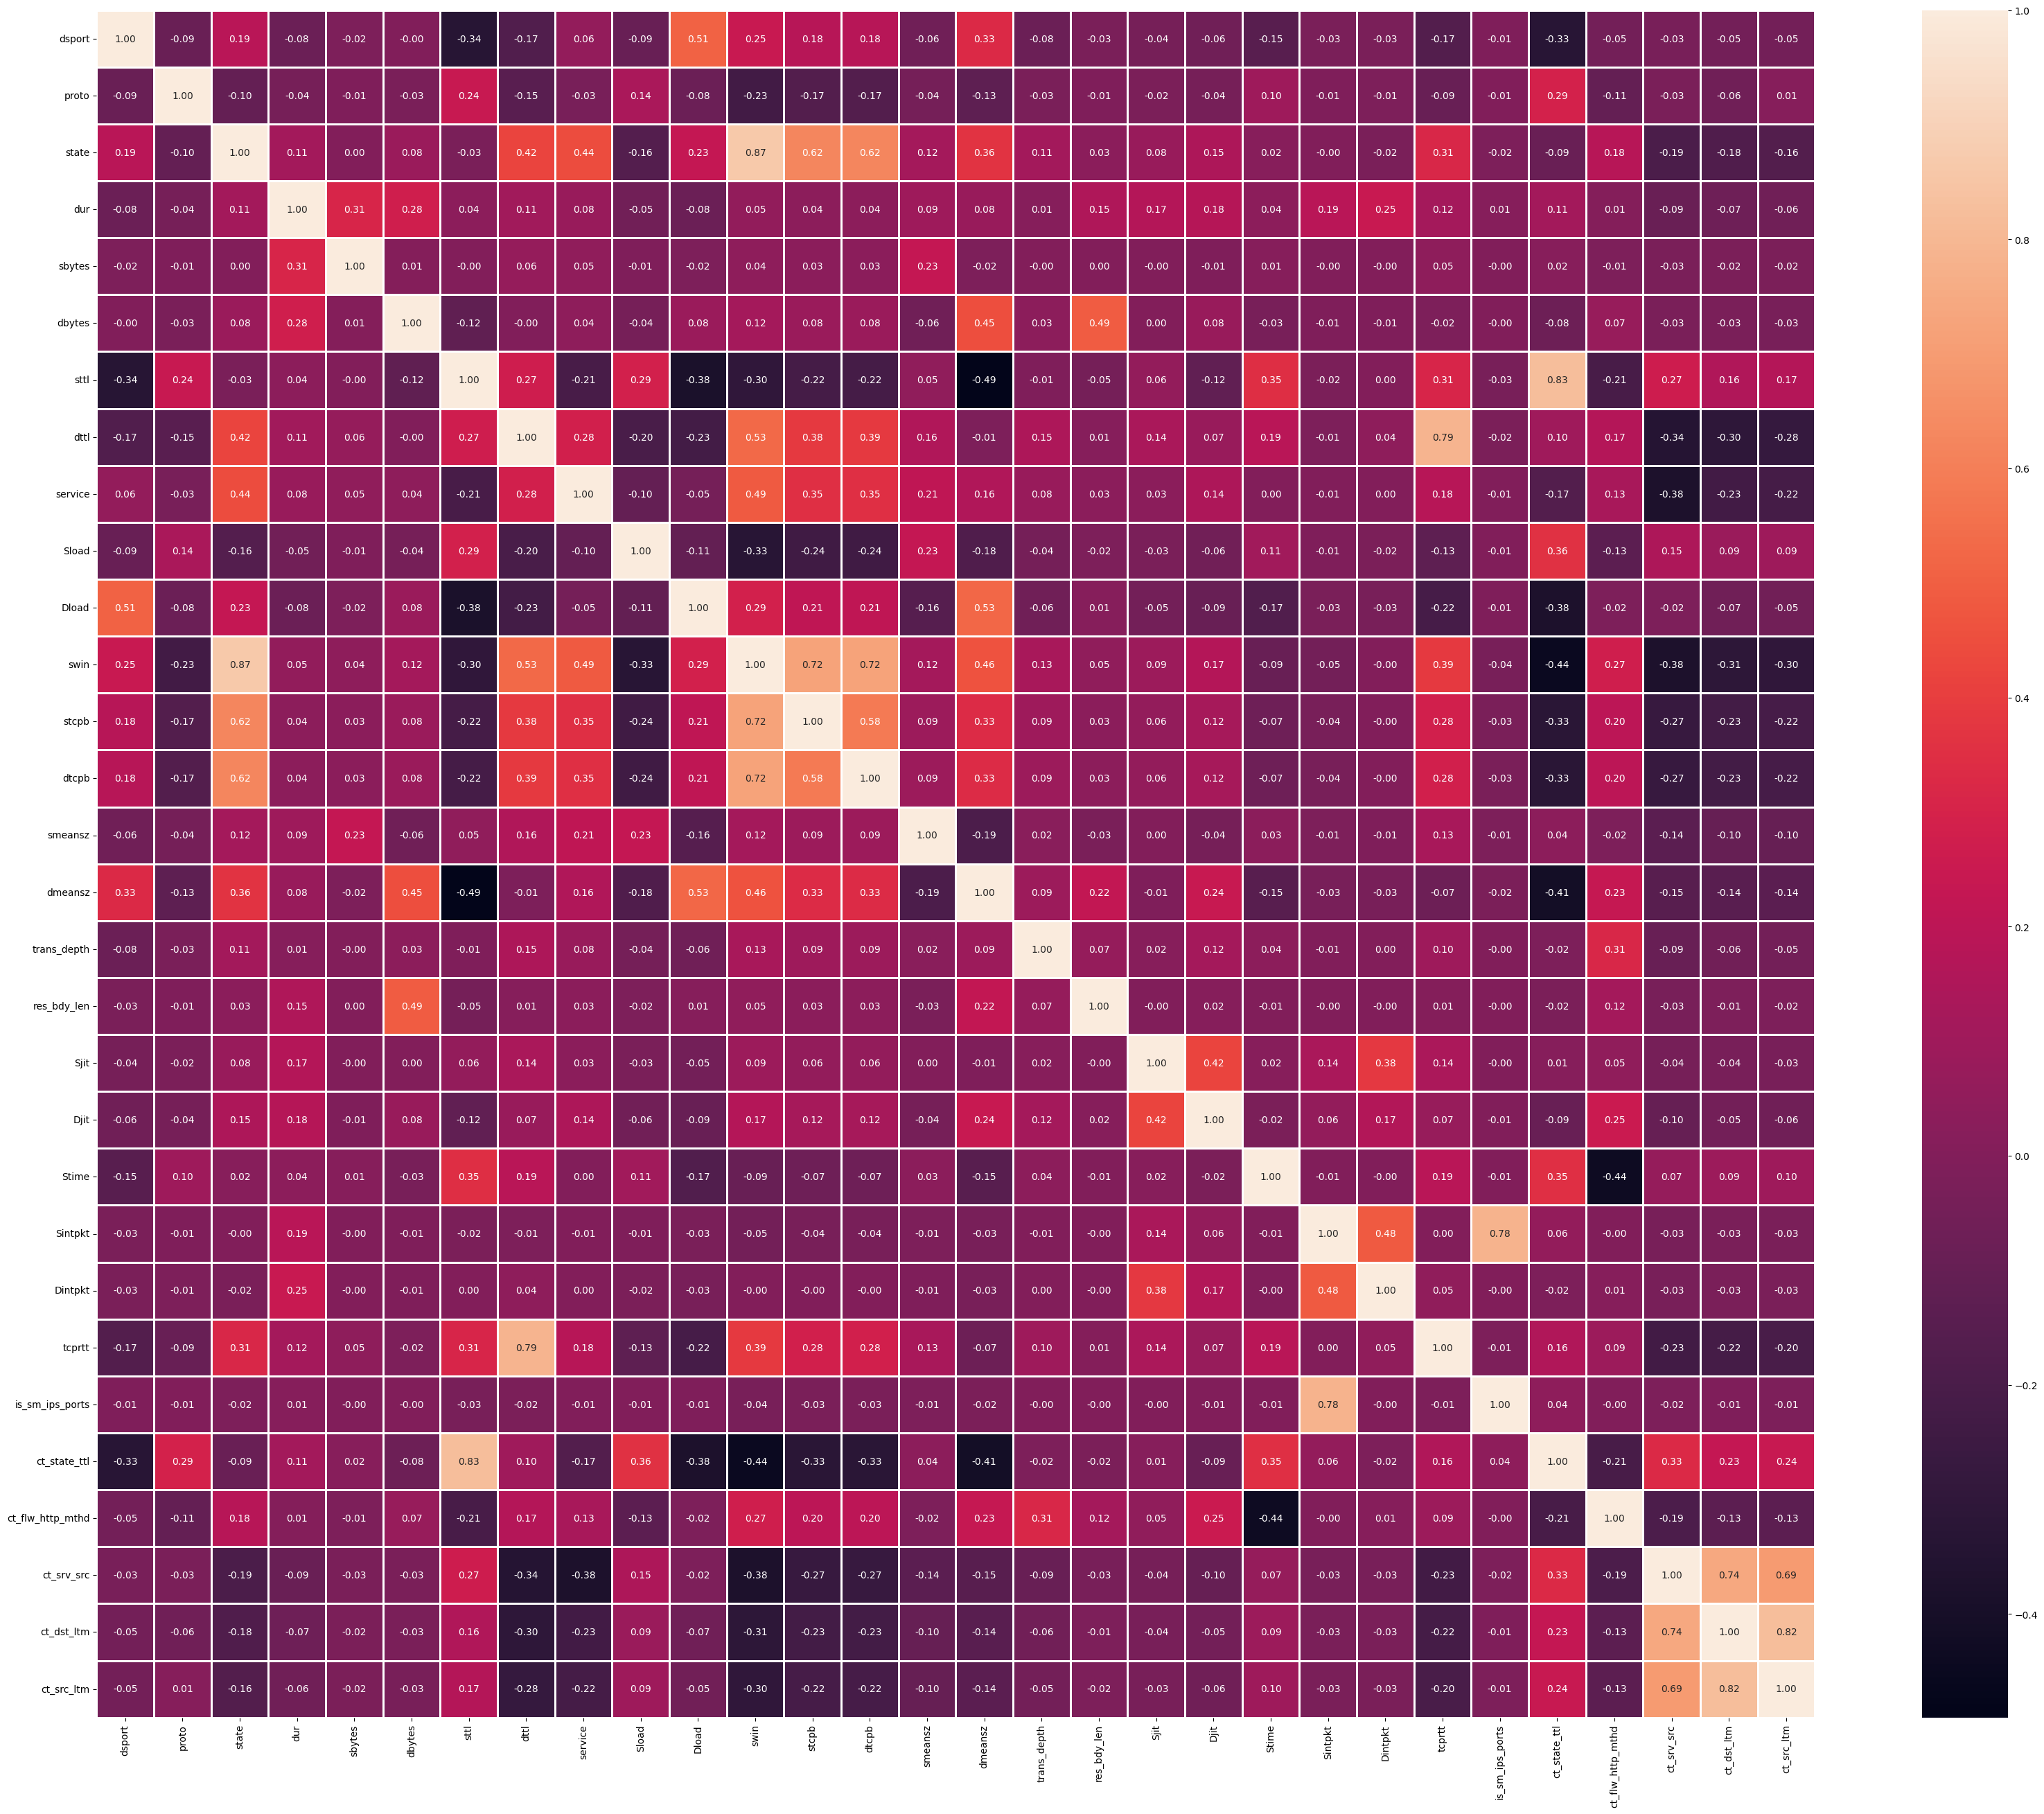

In [72]:
import numpy as np

abs_correlation_matrix = correlation_matrix.abs()

# Select upper triangle of correlation matrix
upper = abs_correlation_matrix.where(np.triu(np.ones(abs_correlation_matrix.shape), k=1).astype(np.bool_))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

# Drop features 
data_preprocessed = data_reduced.drop(to_drop, axis=1)

print(data_preprocessed.info())

f,ax = plt.subplots(figsize=(40,32))

data_without_label = data_preprocessed.drop(columns=['Label'])

correlation_matrix = data_without_label.corr()

sns.heatmap(correlation_matrix, annot=True, linewidths=1, fmt= '.2f',ax=ax)
plt.show()

## Export preprocessed data to csv

In [73]:
data_preprocessed.to_csv("./../assets/UNSW-NB15-preprocessed.csv")